# Tutorial: E-Commerce Images

This tutorial offers a straightforward guide for new users on enhancing product discoverability within an e-commerce platform. 

It demonstrates the creation of an advanced search experience that interprets and reacts to both images and text. 

By integrating the semantic analysis strength of the **OpenAI CLIP model** with the robust indexing features of the **Vantage vector database**, you'll learn how to use both images and text to perform searches over your collections. 

Happy discovering!

## Environment Setup

First, let's begin by installing the necessary prerequisite libraries.

In [ ]:
pip install requests pandas pyarrow ! pip install pydantic==2.6.4 -qU

To install the CLIP model, please follow the instructions provided in their official model [repository](https://github.com/openai/CLIP).

In [1]:
! pip install git+https://github.com/openai/CLIP.git -qU

Finally, you can install the **Vantage** vector database by executing the following command.

In [ ]:
! pip install -i https://test.pypi.org/simple/ vantage-sdk==0.0.13 -qU

After importing the necessary libraries, we are now ready to proceed with the example!

In [251]:
import torch
import clip
from PIL import Image
import requests
import pandas as pd
from io import BytesIO

import vantage
from vantage import VantageClient

## Model Preparation

We'll begin by instantiating the [CLIP model](https://openai.com/research/clip) (`model`), along with a torchvision transform callable (`preprocess`) that converts a PIL image into a tensor. This tensor can then be used as input for the instantiated model.

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

## Helper Functions

In the upcoming cells, we'll develop several helper functions that will be used later during the data preprocessing and querying steps. A brief description will be provided above each function to explain its purpose.

In [145]:
"""
Creates a tuple containing embedding vectors for text and image data, created using the CLIP model. 
Text data is preprocessed/tokenized with the `clip.tokenize` method, 
while image data is preprocessed with the `preprocess` callable, which converts a PIL Image into a tensor.
The preprocessed data is encoded by the CLIP model to produce the embeddings.
"""

def create_clip_text_and_image_embeddings(text_to_embed: str, image_to_embed: Image) -> tuple[list[float], list[float]]:
    clip_preprocessed_text = clip.tokenize(text_to_embed, truncate=True).to(device)
    clip_preprocessed_image = preprocess(image_to_embed).unsqueeze(0).to(device)

    with torch.no_grad():
        clip_text_embedding = model.encode_text(clip_preprocessed_text).tolist()[0]
        clip_image_embedding = model.encode_image(clip_preprocessed_image).tolist()[0]

    return clip_text_embedding, clip_image_embedding

In [146]:
"""
Creates tuple of text and image records compatible with Vantage. 
The text record includes an embedding vector derived from the record's text.
The image record contains an embedding generated from the preprocessed image.
"""

def create_text_and_image_records(record_id: str, record_text: str, record_image_url: str, record_image: Image) -> tuple [dict, dict]:
    clip_text_embedding, clip_image_embedding = create_clip_text_and_image_embeddings(record_text, record_image)

    text_record = {
        "id": record_id + "_text",
        "embeddings": clip_text_embedding,
        "text": record_text
    }

    image_record = {
        "id": record_id + "_image",
        "embeddings": clip_image_embedding,
        "text": record_image_url
    }

    return text_record, image_record

In [147]:
"""
Converts a list of image URL strings into a list of PIL Image objects.
"""

def images_from_urls(image_urls: list) -> list:
    responses = [requests.get(url) for url in image_urls]
    return [Image.open(BytesIO(response.content)) for response in responses]

## Data Preparation

First, let's load our data from the prepared `vantage_furniture_tutorial.parquet` file located in the `data` directory. The data contains information about furniture, including fields such as category, listing URL, image URL, average rating, number of ratings, description, etc.

In [124]:
data = pd.read_parquet("../data/furniture/vantage_furniture_tutorial.parquet")
data = data.sample(500)
data.sample()

id  \
3839  e34d46b5a344f5307103adbfcd1d989b   

                                                   text  \
3839  French Inox Steel Sculptural Console or Sofa T...   

                  meta_category meta_rating_bucket meta_numratings_bucket  \
3839  Console Tables & Cabinets            5 stars               hundreds   

                                               noop_url  noop_rating  \
3839  https://www.etsy.com/listing/1386224059/french...          5.0   

      noop_numratings                                     noop_image_url  \
3839            107.0  https://i.etsystatic.com/12169230/c/2380/1892/...   

                                       noop_description  \
3839  French Inox Steel Sculptural Console or Sofa T...   

                                   noop_title  
3839  French Inox Steel Sculptural Console Or

For our use case, the crucial fields are `id`, `text`, and `noop_image_url`. IDs are unique to each record, `text` includes the item description, and the `noop_image_url` will be used to load the item image. Both the text (description) and the image will be transformed into embeddings in the subsequent steps.

In [125]:
# Prepare IDs
ids = data["id"].to_list()

# Prepare Texts
texts = data["text"].to_list()

# Prepare Images
image_urls = data["noop_image_url"].to_list()
images = images_from_urls(image_urls)

We will iterate over our prepared data to format the records correctly for later uploading. 

This process uses the previously defined `create_text_and_image_records` method. 

The tuple records will contain embedding vectors for both the text and image components of the same item.

In [128]:
data_to_embed = zip(ids, texts, image_urls, images)
tuple_records = [create_text_and_image_records(id, text, url, image) for id, text, url, image in data_to_embed]

Now, we'll unpack our data to obtain a final list of all records. 

Each item included in the starter parquet file will be represented twice: 
- once with the embeddings of its textual description 
- and once with the embeddings of its visual representation, the image.

In [133]:
unpacked_records = [a for tup in tuple_records for a in tup]

We will write our data to a JSON Lines file, which will be used for uploading to the Vantage vector database.

In [136]:
import json

JSONL_DATA_PATH = "ecommerce_images_embeddings.jsonl"

with open(JSONL_DATA_PATH, 'w') as f:
    f.write('\n'.join(map(json.dumps, unpacked_records)))

---

## Vantage

Let's instantiate our `VantageClient` object. For authentication, we will use the Vantage API key, which can be obtained from your Console UI.

In [131]:
vantage_client = VantageClient.using_vantage_api_key(
    vantage_api_key="<YOUR_VANTAGE_API_KEY>",
    account_id="<YOUR_ACCOUNT_ID>",
)

### Data Upload & Indexing

Now, we'll assign some values that will be used to create a new Vantage collection. 

In this use case, since we are providing our own embeddings created in the previous steps, we will set `user_provided_embeddings` to `True`. 

We used our CLIP model for generating these embeddings, which have a dimension of `512`. 

We will also specify an appropriate collection ID, `clip-multimodal`.

In [138]:
COLLECTION_ID = "clip-multimodal"
EMBEDDINGS_DIMENSION = 512
USER_PROVIDED_EMBEDDINGS = True

In [135]:
new_collection = vantage_client.create_collection(
    collection_id=COLLECTION_ID,
    embeddings_dimension=EMBEDDINGS_DIMENSION,
    user_provided_embeddings=USER_PROVIDED_EMBEDDINGS
)

We are now ready to upload our data to the new collection. We simply need to specify the collection ID and the file path.

After initiating the upload, we'll wait a few minutes for our data to be indexed and for our collection to reach the `Online` state. This status indicates that the collection is ready for us to perform search operations on it.

You can monitor the status of your collection through the Console UI by navigating to the page dedicated to your specific collection.

In [139]:
vantage_client.upload_documents_from_path(collection_id=COLLECTION_ID, file_path=JSONL_DATA_PATH)

### Query Preparation

While we wait for our collection to be ready, let's prepare the queries we will use.

We'll try out two types of `Embedding` searches: 
- one using a sample image 
- and the other using a text query. 

After these searches, we'll execute a `MoreLikeThis` search to explore the kind of results we can get using that method. 

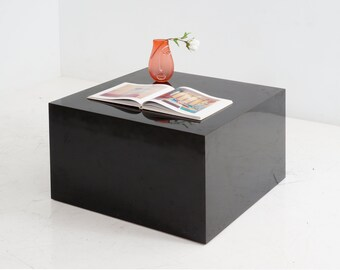

In [224]:
images[20]

#### Embedding Queries Preparation

We will use the image above as our query image and "Small black coffee table" as our text query. 

Since both queries represent similar items, it will be interesting to observe the results and see how well the embedding search can match and retrieve relevant items from our collection. 

This comparison will help demonstrate the effectiveness of using both visual and textual queries within the same dataset.

In [226]:
QUERY_IMAGE_TO_EMBED = images[20]
QUERY_TEXT_TO_EMBED = "Small black coffee table"

In [227]:
clip_query_text_embedding, clip_query_image_embedding = create_clip_text_and_image_embeddings(
    text_to_embed=QUERY_TEXT_TO_EMBED, 
    image_to_embed=QUERY_IMAGE_TO_EMBED
    )

#### MoreLikeThis Query Preparation

For the `MoreLikeThis` search, we'll need to identify the document ID of the item we wish to base our search on. 

We'll use the ID of the same image previously selected for our embedding search. 

Due to the structure of our dataset, where each item is represented by two records (one for text embeddings and another for image embeddings), the index of the image has effectively doubled. Originally at index **20**, it is now at **41** to reflect this dual representation. 

Therefore, the record at index 40 corresponds to the textual representation, while the record at index 41 corresponds to the image representation of the item. 

In [265]:
unpacked_records[40]["text"]

'Black Cube Table, 1980s Step into the \'80s with this sleek black laminate cube table – your coffee table, your style statement, your postmodern delight. Your\xa0living room\xa0upgrade has arrived.- 18.5"h, 30"w, 30"d- Black laminate- Condition: Excellent Black Cube Table, 1980s Home & Living Furniture Living Room Furniture Coffee & End Tables'

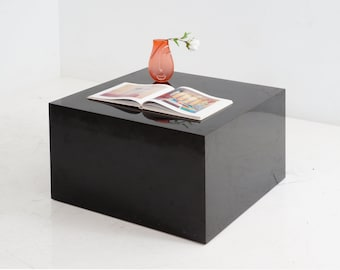

In [267]:
images_from_urls([unpacked_records[41]["text"]])[0]

In [266]:
QUERY_TEXT_DOCUMENT_ID = unpacked_records[40]["id"]
QUERY_IMAGE_DOCUMENT_ID = unpacked_records[41]["id"]

## Search

Now that we're ready, the following cells will be dedicated to executing our search operations. 

We'll perform two embedding searches — one with a sample image and the other with a text query, and following these, we'll perform two MoreLikeThis searches over the same collection.

### Embedding Search

**Embedding Search** works by internally comparing the embedding query vectors with the embedding vectors stored in the collection. 

**Vantage** handles all similarity calculations internally and returns the documents/records that are most similar to our query embedding vectors. This process efficiently identifies and ranks the records in the collection based on their relevance to the query.

In [228]:
image_embedding_results = vantage_client.embedding_search(embedding=clip_query_image_embedding, collection_id=COLLECTION_ID)
text_embedding_results = vantage_client.embedding_search(embedding=clip_query_text_embedding, collection_id=COLLECTION_ID)

### More Like This Search

**MoreLikeThis Search** operates similarly to the embedding search previously described, with the key difference being that instead of directly providing an embedding vector, we supply a document ID that exists within our collection. 

**Vantage** then returns the most similar documents/records to the one specified, ranking the results based on their relevance to our query document. This approach allows for an intuitive method of finding items similar to a known reference point within the dataset.

In [268]:
more_like_this_image_results = vantage_client.more_like_this_search(document_id=QUERY_IMAGE_DOCUMENT_ID, collection_id=COLLECTION_ID)
more_like_this_text_results = vantage_client.more_like_this_search(document_id=QUERY_TEXT_DOCUMENT_ID, collection_id=COLLECTION_ID)

### Search Results Analysis

To visualize our search results effectively, we will implement a simple helper function. 

This function will enrich our search results with `image_url` and `image` fields for each result and then display each result as image.

In [258]:
def display_search_results(search_results: vantage.SearchResult):
    result_dicts = [res.model_dump() for res in search_results.results]

    for res in result_dicts:
        if str(res["id"]).endswith("_text"):
            res["text"] = [record["text"] for record in unpacked_records if record["id"] == res["id"]]
            res["image_url"] = [record["text"] for record in unpacked_records if record["id"] == res["id"][:32] + "_image"]
        else:
            res["image_url"] = [record["text"] for record in unpacked_records if record["id"] == res["id"]]
        res["image"] = images_from_urls(res["image_url"])[0]
        print("Score:", res["score"])
        display(res["image"])
        

#### Embedding Search - *Image Query Embeddings*

Score: 1.0


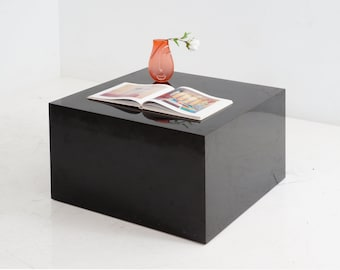

Score: 0.9178305268287659


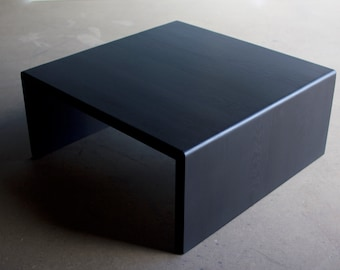

Score: 0.9162589311599731


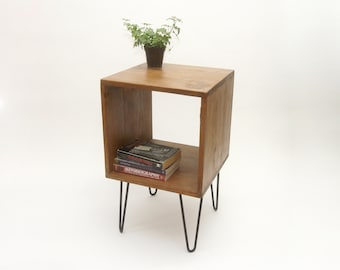

Score: 0.9141099452972412


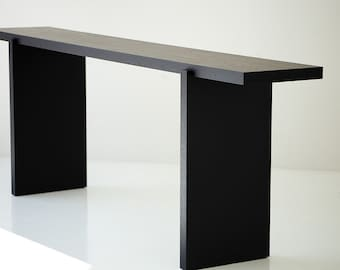

Score: 0.9118581414222717


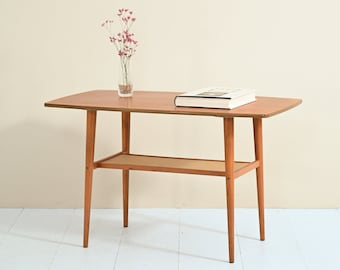

Score: 0.9109896421432495


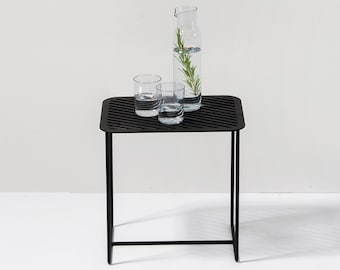

Score: 0.9102115035057068


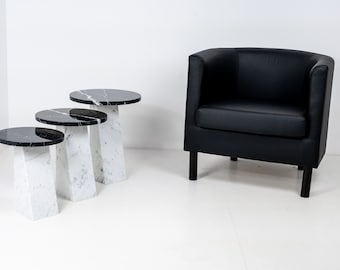

Score: 0.9083223342895508


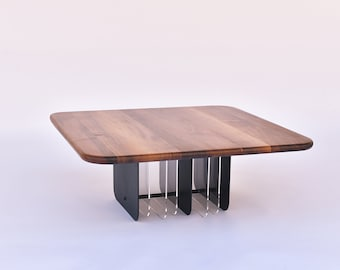

Score: 0.9069623351097107


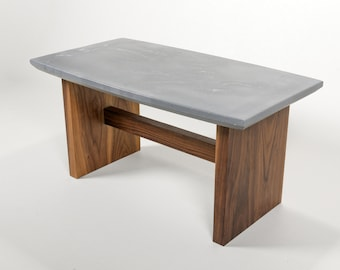

Score: 0.9067561626434326


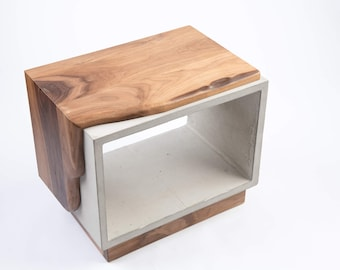

In [259]:
display_search_results(image_embedding_results)

#### Embedding Search - *Text Query Embeddings*

Score: 0.8718411326408386


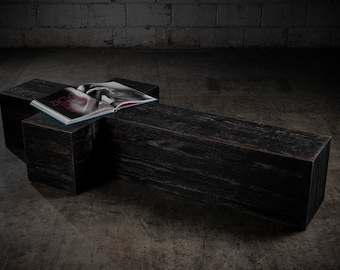

Score: 0.8604828119277954


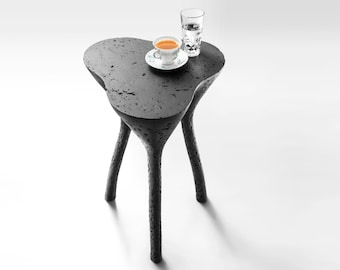

Score: 0.8521502017974854


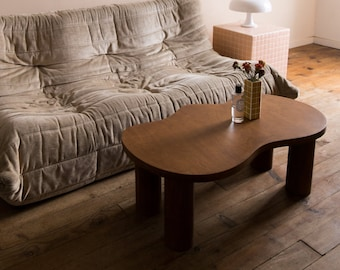

Score: 0.8511613607406616


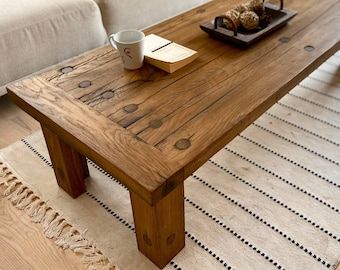

Score: 0.8491078615188599


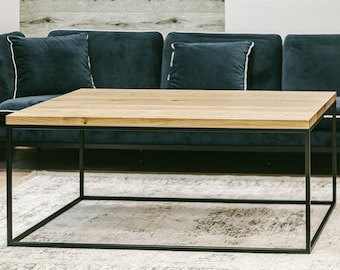

Score: 0.8465099334716797


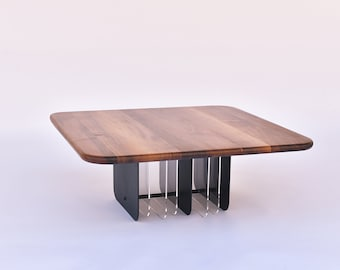

Score: 0.8416081666946411


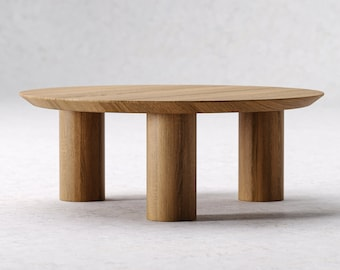

Score: 0.840140700340271


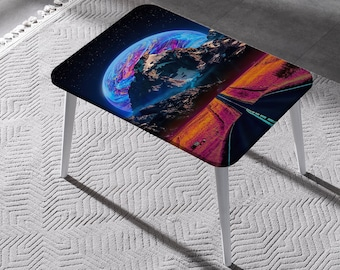

Score: 0.8371195793151855


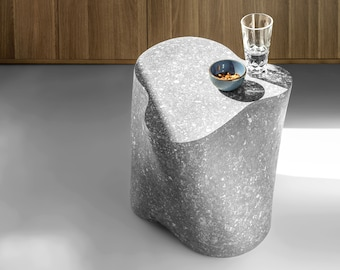

Score: 0.8348848223686218


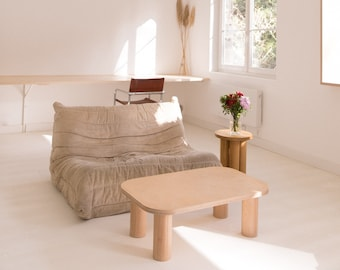

In [260]:
display_search_results(text_embedding_results)

#### More Like This Search - *Document ID with Image Embeddings*

Score: 1.0


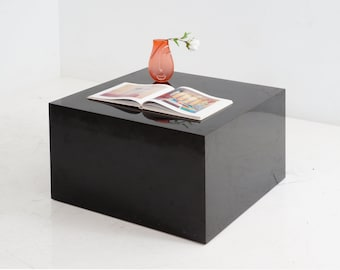

Score: 0.9178305268287659


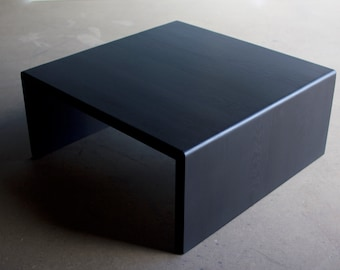

Score: 0.9162589311599731


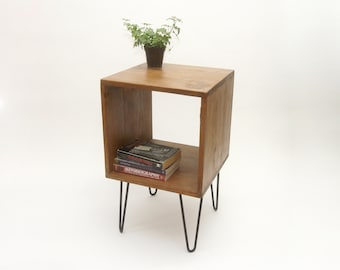

Score: 0.9083223342895508


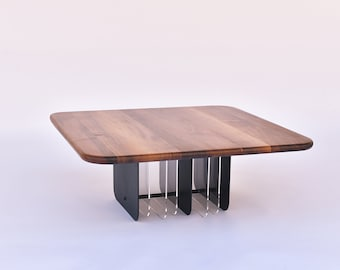

Score: 0.9069623351097107


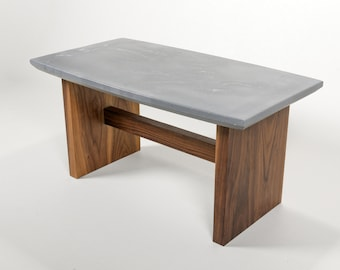

Score: 0.9060010313987732


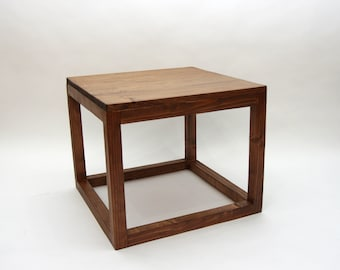

Score: 0.905755877494812


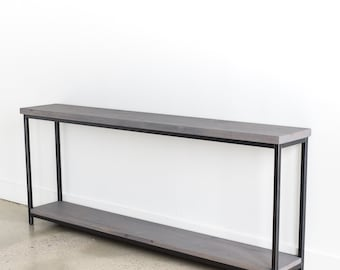

Score: 0.9014963507652283


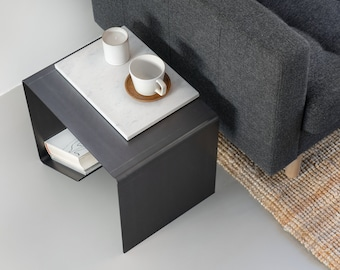

Score: 0.901474118232727


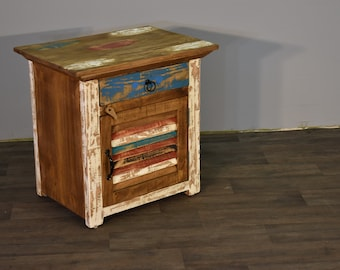

Score: 0.9010244607925415


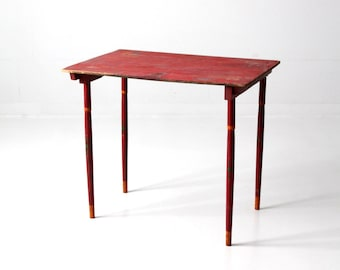

In [271]:
display_search_results(more_like_this_image_results)

#### More Like This Search - *Document ID with Text Embeddings*

Score: 1.0


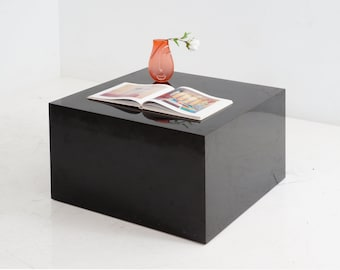

Score: 0.8729774951934814


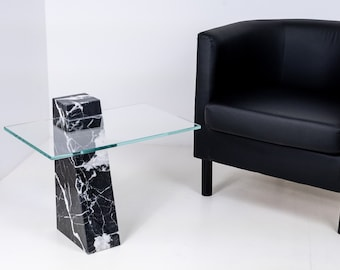

Score: 0.8068034648895264


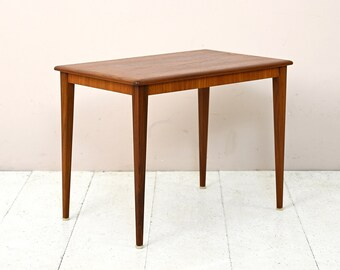

Score: 0.8066110610961914


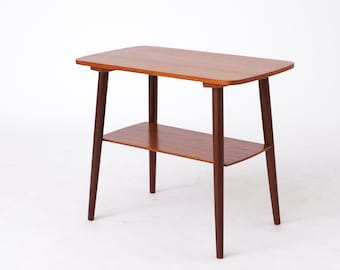

Score: 0.7531618475914001


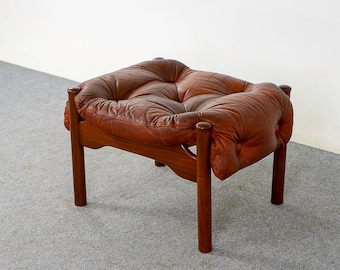

In [269]:
display_search_results(more_like_this_text_results)

### Conclusion

We can see that all of our search results returned items that are similar to our queries. 

While the results are not identical — due to the slight differences in the methods used for each search — the similarity across items effectively demonstrates the efficiency of both **Embedding** searches and **MoreLikeThis** searches. This also highlights the versatility of accepting **both text and image inputs** for queries.

We hope this tutorial has been informative and helpful to you! For further exploration and more use cases, feel free to check out our other tutorials or examples.

Happy discovering!